In [2]:
# 导库
import numpy as np
import random
import torch
from torch import nn
from torch import tensor
from d2l import torch as d2l
import torch.utils.data as Data
from Common.function.graph_plot import plot
from Common.function.machine_learning import Train

tensor([-323.7527, -279.5858, -147.1200, -146.3422, -138.1503, -131.0376,
        -125.8239, -115.5888,  -92.6177,  -79.5648,  -77.1312,  -65.5436,
         -64.2297,  -60.3712,  -52.8452,  -44.2722,  -43.8005,  -40.6126,
         -36.7179,  -31.3475,  -28.1199,  -24.9172,  -24.7204,  -20.6993,
         -19.2847,  -18.2497,   -5.1766,   -4.5558,    2.1726,    9.7426,
          16.6371,   16.9422,   20.0768,   35.5664,   41.0190,   42.0191,
          52.2193,   52.4343,   52.9711,   61.4214,   70.6958,   72.0541,
          84.1368,  100.1990,  109.2871,  143.4245,  149.1769,  159.0761,
         159.1118,  269.5126])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(tensor([[-323.7527],
         [-279.5858],
         [-147.1200],
         [-146.3422],
         [-138.1503],
         [-131.0376],
         [-125.8239],
         [-115.5888],
         [ -92.6177],
         [ -79.5648]]),
 tensor([[-453.3904],
         [-336.4441],
         [-216.7329],
         [-137.6374],
         [-191.0971],
         [-166.8999],
         [-167.1905],
         [ -80.9117],
         [-181.9144],
         [-242.5287]]))

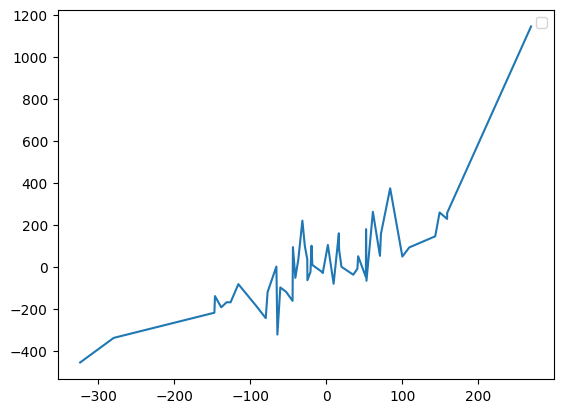

In [704]:
# 获取数据
x = 100 * torch.randn(50)
sorted_x, _ = torch.sort(x, dim=0)
print(sorted_x)
x = sorted_x.reshape(x.shape[0], 1)
x_copy = torch.t_copy(x)


# f = torch.square
# def f(x):
#     return 0.01 * x ** 2 - 0.0001 * x ** 3 + 5 * x - 5 * torch.log(x + 400)


#
# def f(x):
#     return torch.relu(0.001 * x ** 3 - 0.05 * x ** 2 + x - 0.01*torch.exp(x/10))/10

def f0(x):
    return 10 * torch.log(x + 400) - 0.001 * x ** 3


def f1(x):
    return 5 * x


def f2(x):
    return 0.05 * x ** 2


def f3(x):
    return torch.exp(x/40) + x


f = f3
y = f(x) + 100 * torch.randn(50, 1)
plot(x, [y])
x[0:10], y[0:10]

In [705]:
# 生成数据集
dataSet = Data.TensorDataset(x, y)
data_iter = Data.DataLoader(dataSet, batch_size=100, shuffle=True)

In [706]:
def n_relu(a, b, x):
    mask = x > 0
    a_copy = a.repeat(len(x)).reshape(len(x), len(a))
    b_copy = b.repeat(len(x)).reshape(len(x), len(b))
    x[mask] = x[mask] + a_copy[mask] * torch.pow(x[mask] + 1, b_copy[mask]) - a_copy[mask]
    return x

In [707]:
# 1.搭建模型
# baseline
class Baseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = nn.Parameter(torch.randn(1, 20))  # 2.初始化
        self.b1 = nn.Parameter(torch.randn(20))
        self.w2 = nn.Parameter(torch.randn(20, 20))
        self.b2 = nn.Parameter(torch.randn(20))
        self.w3 = nn.Parameter(torch.randn(20, 1))
        self.b3 = nn.Parameter(torch.randn(1))

    def forward(self, x):
        y1 = torch.relu(torch.matmul(x, self.w1) + self.b1)
        y2 = torch.relu(torch.matmul(y1, self.w2) + self.b2)
        y3 = torch.matmul(y2, self.w3) + self.b3
        return y3


# 使用新型激活函数
class NewActivation(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = nn.Parameter(torch.randn(1, 20))  # 2.初始化
        self.b1 = nn.Parameter(torch.randn(20))
        self.w2 = nn.Parameter(torch.randn(20, 20))
        self.b2 = nn.Parameter(torch.randn(20))
        self.w3 = nn.Parameter(torch.randn(20, 1))
        self.b3 = nn.Parameter(torch.randn(1))
        self.a_1 = torch.nn.Parameter(0.01 * (torch.randn(20)))
        self.b_1 = torch.nn.Parameter(0.01 * (torch.randn(20)) + 1)
        self.a_2 = torch.nn.Parameter(0.01 * (torch.randn(20)))
        self.b_2 = torch.nn.Parameter(0.01 * (torch.randn(20)) + 1)

    def forward(self, x):
        y1 = n_relu(self.a_1, self.b_1, torch.matmul(x, self.w1) + self.b1)
        y2 = n_relu(self.a_2, self.b_2, torch.matmul(y1, self.w2) + self.b2)
        y3 = torch.matmul(y2, self.w3) + self.b3
        return y3

In [708]:
new = NewActivation()
base = Baseline()

In [709]:
# 3.定义损失函数
loss = torch.nn.MSELoss()

In [710]:
# 4.定义优化器
learning_rate1 = 0.1
learning_rate2 = 0.01
optimizer1 = torch.optim.Adam(base.parameters(), lr=learning_rate1)
optimizer2 = torch.optim.Adam(new.parameters(), lr=learning_rate2)

In [711]:
# 改写训练函数
a_decay = 100
b_decay = 10000


class TrainNew(Train):
    def __init__(self, model, optimizer, loss):
        super().__init__(model, optimizer, loss)

    def loss_in_single_batch(self, x, y):
        y_hat = self.model(x)
        l = self.loss(y, y_hat)
        return l

In [712]:
train1 = Train(base, optimizer1, loss)
train2 = TrainNew(new, optimizer2, loss)

In [713]:
train1.reset_optimizer(optimizer1)
train2.reset_optimizer(optimizer2)

testing 01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


training loss: 625.846953125, training time: 2.9574708938598633
testing 01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


training loss: 198.03228515625, training time: 6.803006172180176


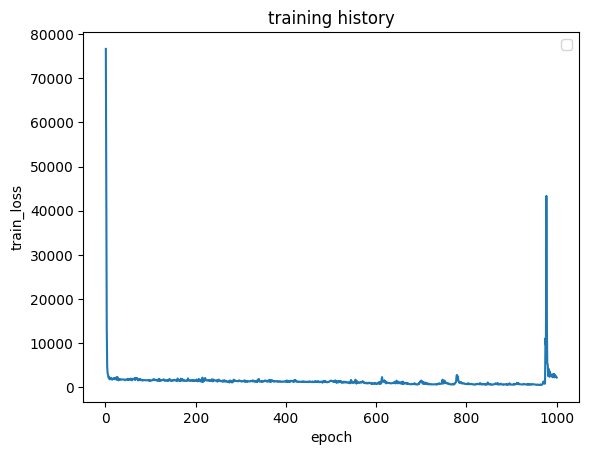

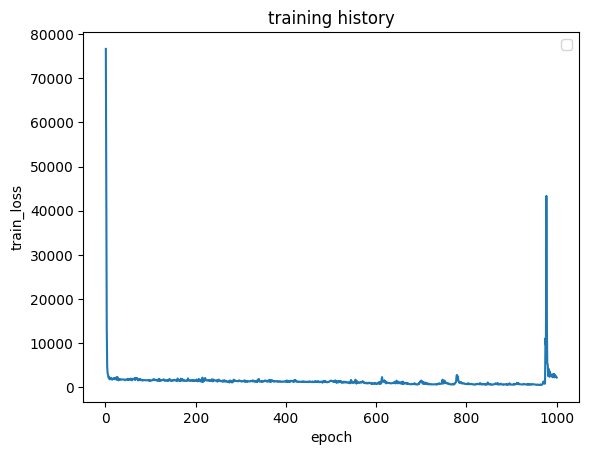

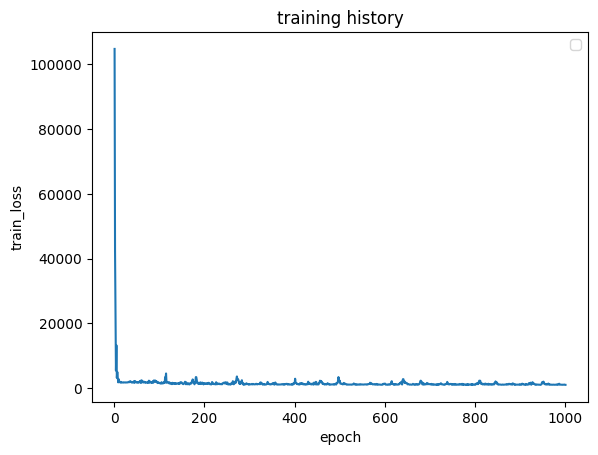

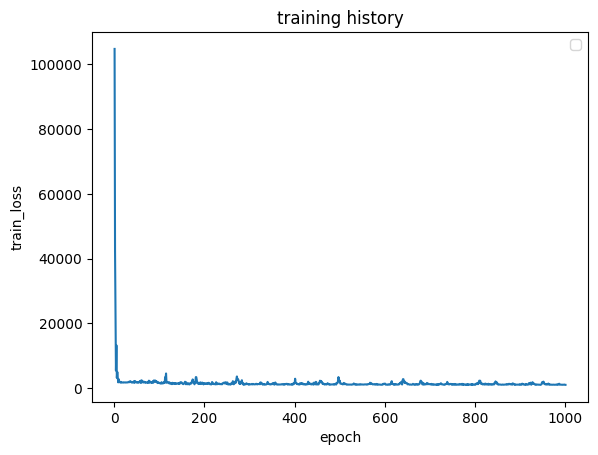

In [714]:
# batch训练
epoch_num = 1000
batch_range = 10
list1 = train1(dataSet, epoch_num, batch_range)
list2 = train2(dataSet, epoch_num, batch_range)

In [715]:
# 全局训练
global_train = False
if global_train:
    epoch_num = 100
    list3 = train1(dataSet, epoch_num, len(dataSet))
    list4 = train2(dataSet, epoch_num, len(dataSet))

In [716]:
list2[-6]

1041.58443359375

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


训练误差：2232.79748046875


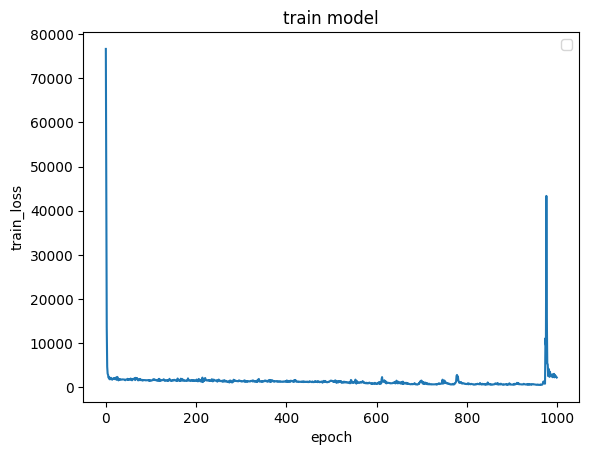

In [717]:
print(f"训练误差：{float(list1[-1])}")
plot(np.array(range(len(list1))), [list1], xlabel="epoch", ylabel="train_loss", title=f"train model")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


训练误差：1002.094130859375


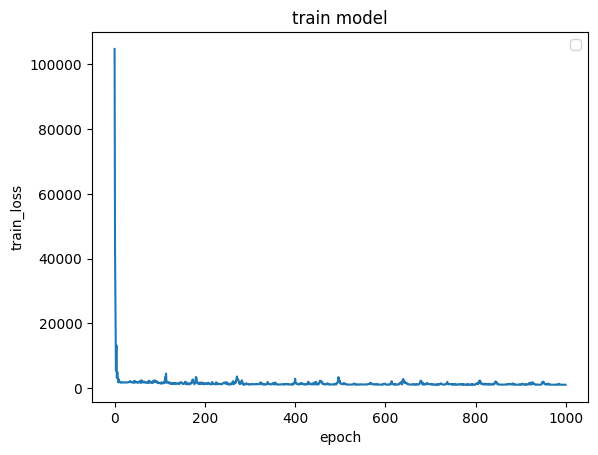

In [718]:
print(f"训练误差：{float(list2[-1])}")
plot(np.array(range(len(list2))), [list2], xlabel="epoch", ylabel="train_loss", title=f"train model")

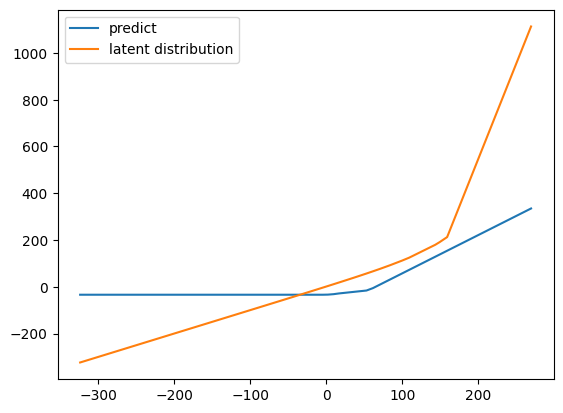

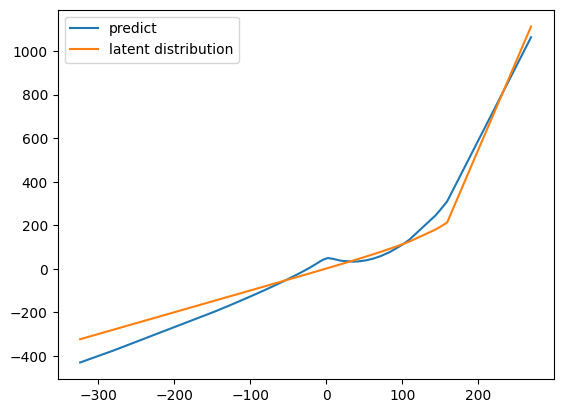

In [719]:
x = x_copy.reshape(x_copy.shape[1], 1)
y_hat1 = base(x)
y_hat2 = f(x)
plot(x, [y_hat1.detach().numpy(), y_hat2], labels=["predict", "latent distribution"])

y_hat1 = new(x)
y_hat2 = f(x)
plot(x, [y_hat1.detach().numpy(), y_hat2], labels=["predict", "latent distribution"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


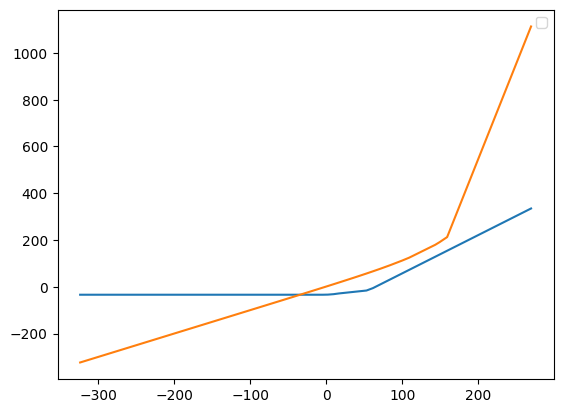

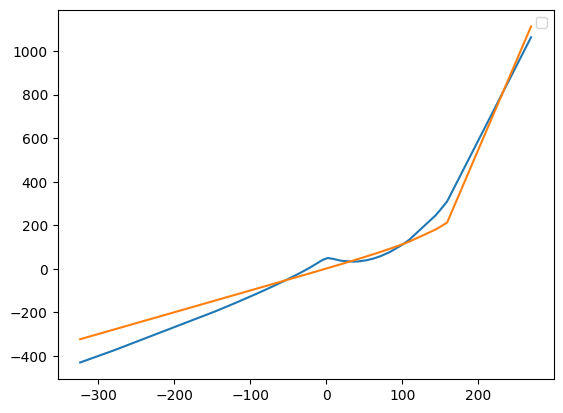

In [720]:
# print(x_copy)
# print(x)
x = x_copy.reshape(x_copy.shape[1], 1)
y_hat1 = base(x)
y_hat2 = f(x)
plot(x, [y_hat1.detach().numpy(), y_hat2])

y_hat1 = new(x)
y_hat2 = f(x)
plot(x, [y_hat1.detach().numpy(), y_hat2])

In [721]:
def p(*x):
    a(*x)
    # for i in x:
    #     print(i)
    #     print(type(i))


def a(x, y, z):
    print(x)
    print(y)
    print(z)
    print(x + y + z)


x = torch.tensor([1, 2, 3, 4, 5])
y = torch.tensor([2, 3, 4, 5, 6])
z = torch.tensor([3, 4, 5, 6, 7])
data_set_test = Data.TensorDataset(x, y, z)
data_iter2 = Data.DataLoader(data_set_test, 2, True)
for k in data_iter2:
    print(k)
    p(*k)
    break

[tensor([2, 3]), tensor([3, 4]), tensor([4, 5])]
tensor([2, 3])
tensor([3, 4])
tensor([4, 5])
tensor([ 9, 12])


In [722]:
# draft paper
def decorator_function(original_function):
    def wrapper_function():
        print("修饰器添加的功能")
        original_function()

    return wrapper_function


@decorator_function
def greet():
    print("欢迎使用修饰器")


greet()


def total_loss(custom_loss):
    def loss1():
        l = custom_loss


修饰器添加的功能
欢迎使用修饰器


In [723]:
o = tensor([1, 2, 3, 4])
c = tensor([2, 2, 2, 2])
d = torch.pow(c, o)

In [724]:
d * o

tensor([ 2,  8, 24, 64])

In [725]:
res = o.repeat(3).reshape(3, 4)
res

tensor([[1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4]])

In [726]:
w_ = tensor([[1, 2, 3], [4, 5, 6]])
w_.repeat(2, 4)

tensor([[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3],
        [4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6],
        [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3],
        [4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6]])

In [727]:
a = tensor([1])
oo = [a, a, a, a]
em = []
em = [*em, *oo]
em = [*em, *oo]
em

[tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1])]

In [728]:
aa = tensor([[1], [2], [4], [5], [6]])
aaa = Data.TensorDataset(aa)
print(len(aaa))
aaaa = Data.DataLoader(aaa, batch_size=2, shuffle=True)
for a__ in aaaa:
    print(a__)

5
[tensor([[4],
        [5]])]
[tensor([[2],
        [6]])]
[tensor([[1]])]
